In [2]:
# !pip install seaborn
import pandas as pd
import numpy as np # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
import base64
import string
import re
from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')


In [3]:
df = pd.read_csv('C:/data/CS/SA/threshold4_balanced_training_set.csv', usecols=['CONTENT','sentiment'])
df.head(10)
df['label']=df['sentiment']
df['label'].value_counts()

negative    1269
positive    1269
neutral     1269
Name: label, dtype: int64

In [4]:
for i, item in enumerate (df['label']):
  if item=='positive':
    df['label'][i]=2
  if item=='neutral':
    df['label'][i]=1
  if item=='negative':
    df['label'][i]=0
df['label'].value_counts()

2    1269
1    1269
0    1269
Name: label, dtype: int64

In [5]:
tdf = pd.read_csv('C:/data/CS/SA/test.csv')
x = df['CONTENT']
y = df['label']
x_test=tdf['CONTENT']
y_test=tdf['label']
corpus=df['CONTENT'].append(tdf['CONTENT'])
len(corpus)

4177

In [6]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(df, test_size=0.2, random_state=42)

In [14]:
import spacy
from spacy.lang.en import English
import en_core_web_sm

# load en_core_web_sm of English for vocabluary, syntax & entities
nlp = en_core_web_sm.load()


punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-pron-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [15]:
pos_text = [text for text in train[train['label'] == 2]['CONTENT']]

neg_text = [text for text in train[train['label'] == 0]['CONTENT']]
neu_text = [text for text in train[train['label'] == 1]['CONTENT']]

pos_clean = cleanup_text(pos_text)
pos_clean = ' '.join(pos_clean).split()

neg_clean = cleanup_text(neg_text)
neg_clean = ' '.join(neg_clean).split()

neu_clean = cleanup_text(neu_text)
neu_clean = ' '.join(neu_clean).split()


pos_counts = Counter(pos_clean)
neg_counts = Counter(neg_clean)
neu_counts = Counter(neu_clean)

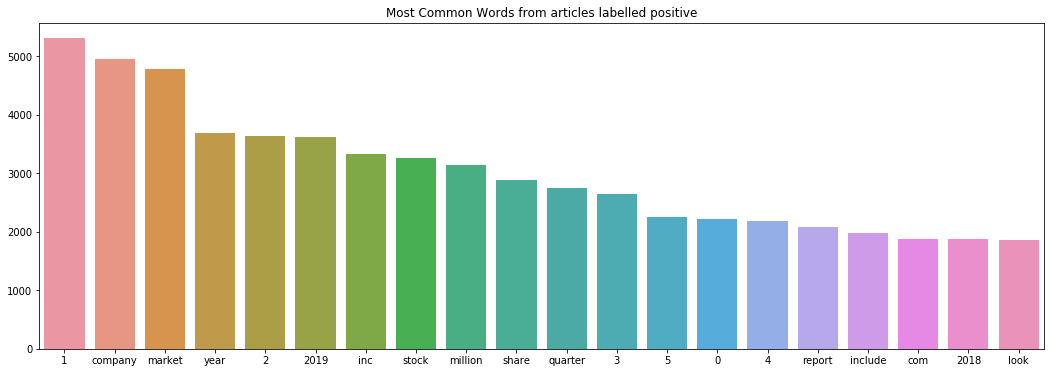

In [16]:
pos_common_words = [word[0] for word in pos_counts.most_common(20)]
pos_common_counts = [word[1] for word in pos_counts.most_common(20)]

fig = plt.figure(figsize=(18,6))
sns.barplot(x=pos_common_words, y=pos_common_counts)
plt.title('Most Common Words from articles labelled positive')
plt.show()

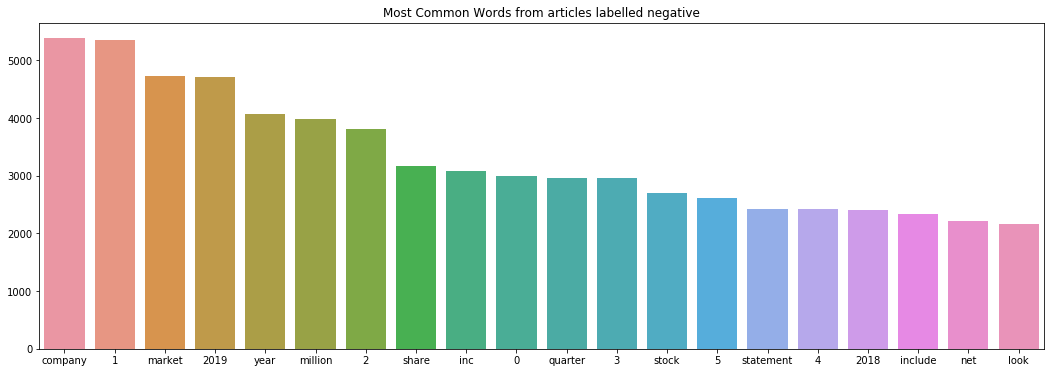

In [17]:
neg_common_words = [word[0] for word in neg_counts.most_common(20)]
neg_common_counts = [word[1] for word in neg_counts.most_common(20)]

fig = plt.figure(figsize=(18,6))
sns.barplot(x=neg_common_words, y=neg_common_counts)
plt.title('Most Common Words from articles labelled negative')
plt.show()

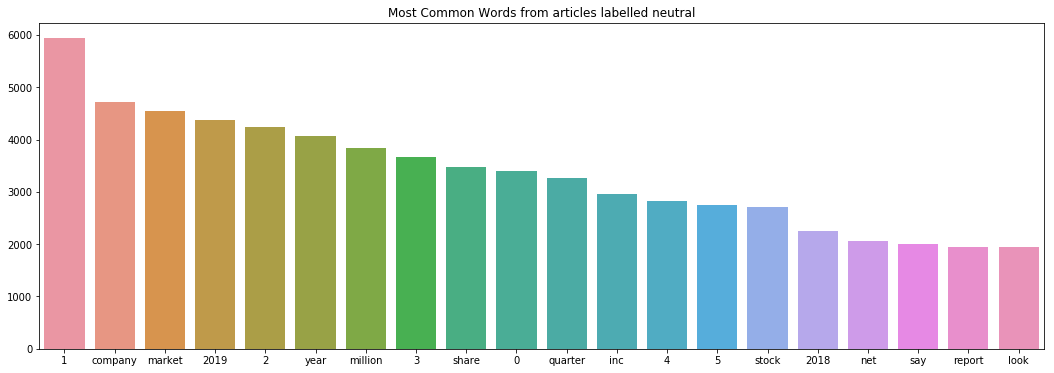

In [18]:
neu_common_words = [word[0] for word in neu_counts.most_common(20)]
neu_common_counts = [word[1] for word in neu_counts.most_common(20)]

fig = plt.figure(figsize=(18,6))
sns.barplot(x=neu_common_words, y=neu_common_counts)
plt.title('Most Common Words from articles labelled neutral')
plt.show()

In [19]:
validation.head()

,CONTENT,sentiment,label
1011,pune india july 24 2019 globe newswire frozen ...,neutral,1
3182,the follow be a roundup of top development in ...,negative,0
3350,san francisco dec 20 2018 globe newswire sunru...,negative,0
897,south san francisco calif jan 23 2019 globe ne...,neutral,1
2293,investor in scynexis inc scyx need to pay clos...,positive,2


In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
import string
import re
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()

In [21]:
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]

In [22]:
class CleanTextTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}
    
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text

def tokenizeText(sample):
    tokens = parser(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens

In [31]:
def printNMostInformative(vectorizer, clf, N):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    topClass1 = coefs_with_fns[:N]
    topClass2 = coefs_with_fns[:-(N + 1):-1]
    print("Class 1 best: ")
    for feat in topClass1:
        print(feat)
    print("Class 2 best: ")
    for feat in topClass2:
        print(feat)

vectorizer = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1,3))
#vectorizer = TfidfVectorizer(tokenizer=tokenizeText, ngram_range=(1,3))
clf = LogisticRegression()
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', clf)])

# data
train1 = train['CONTENT'].tolist()
labelsTrain1 = train['label'].tolist()

val1 = validation['CONTENT'].tolist()
labelsVal1 = validation['label'].tolist()
# train
pipe.fit(train1, labelsTrain1)

# test
preds = pipe.predict(val1)
print("accuracy:", accuracy_score(labelsVal1, preds))
# print("Top 10 features used to predict: ")

# printNMostInformative(vectorizer, clf, 10)

pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer)])
transform = pipe.fit_transform(train1, labelsTrain1)
vocab = vectorizer.get_feature_names()

for i in range(len(train1)):
    s = ""
    indexIntoVocab = transform.indices[transform.indptr[i]:transform.indptr[i+1]]
    numOccurences = transform.data[transform.indptr[i]:transform.indptr[i+1]]
    for idx, num in zip(indexIntoVocab, numOccurences):
        s += str((vocab[idx], num))

accuracy: 0.5997375328083989


In [32]:
from sklearn import metrics
print(metrics.classification_report(labelsVal1, preds, 
                                    target_names=df['sentiment'].unique()))

              precision    recall  f1-score   support

     neutral       0.51      0.57      0.54       226
    positive       0.68      0.64      0.66       279
    negative       0.60      0.58      0.59       257

    accuracy                           0.60       762
   macro avg       0.60      0.60      0.60       762
weighted avg       0.60      0.60      0.60       762

